In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib

In [3]:
import os
import logging
import argparse
import glob
import json
from collections import Counter

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config


In [4]:
os.chdir('/home/walml/repos/zoobot')

In [5]:
catalog_loc = 'data/gz2/prepared_catalogs/all_featp5_facep5_2p5_unfiltered/labelled_catalog.csv'
catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/gz2/png' + x[32:])
catalog['id_str'] = catalog['dr7objid'].apply(lambda x: 'dr7objid_' + str(x))

In [6]:
questions = [
    'smooth-or-featured',
    'has-spiral-arms',
    'bar',
    'bulge-size'
]

# decals cols
# version = 'decals'
# label_cols = [
#     'smooth-or-featured_smooth',
#     'smooth-or-featured_featured-or-disk',
#     'has-spiral-arms_yes',
#     'has-spiral-arms_no',
#     'bar_strong',
#     'bar_weak',
#     'bar_no',
#     'bulge-size_dominant',
#     'bulge-size_large',
#     'bulge-size_moderate',
#     'bulge-size_small',
#     'bulge-size_none'
# ]

# gz2 cols
version = 'gz2'
label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
    'bar_yes',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_obvious',
    'bulge-size_just-noticeable',
    'bulge-size_no'
]

schema = losses.Schema(label_cols, questions, version=version)

batch_size = 16
initial_size = 300
final_size = 224
channels = 3

n_samples = 15


{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7fc3bd4f6d50>: (2, 3), bar, indices 4 to 5, asked after <zoobot.estimators.losses.Answer object at 0x7fc3bd4f6d50>: (4, 5), bulge-size, indices 6 to 9, asked after <zoobot.estimators.losses.Answer object at 0x7fc3bd4f6d50>: (6, 9)}


In [7]:
def get_dataset(tfrecord_dir):
    tfrecord_locs = glob.glob(tfrecord_dir + '/*.tfrecord')
    eval_config = run_estimator_config.get_eval_config(tfrecord_locs, label_cols, batch_size, initial_size, final_size, channels)
    eval_config.drop_remainder = False
    return input_utils.get_input(config=eval_config)

In [8]:
# copied from trust_the_model.ipynb
def show_galaxies(galaxies, scale=3, nrows=6, ncols=6):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows, scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = np.squeeze(galaxies[galaxy_n])
            ax = plt.subplot(gs1[row_n, col_n])
            ax.imshow(galaxy)
#             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
#             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
#             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


In [9]:
tfrecord_dir = 'results/temp/latest_dirichlet_unfiltered_active_m3_warm/iteration_1/acquired_tfrecords'

In [10]:
dataset = get_dataset(tfrecord_dir)

(16, 300, 300, 1)
(16, 10)
(16, 300, 300, 1)
(16, 10)
(16, 300, 300, 1)
(16, 10)
(16, 300, 300, 1)
(16, 10)
tf.Tensor(
[[ 0. 46. 44.  0. 10. 34.  0.  1. 37.  6.]
 [18. 20. 12.  2.  1. 13.  0.  1.  3. 10.]
 [30. 10.  0. 10.  7.  3.  1.  5.  3.  1.]
 [30. 12.  1.  5.  1.  5.  0.  5.  1.  0.]
 [ 2. 43. 41.  1. 24. 18.  0.  9. 33.  0.]
 [ 9. 32. 23.  1.  4. 20.  0.  1. 20.  3.]
 [ 0. 40. 40.  0.  3. 37. 17. 19.  4.  0.]
 [11. 35. 11.  8.  1. 18.  0. 11.  8.  0.]
 [ 1. 44. 41.  0. 37.  4.  0. 11. 30.  0.]
 [32.  4.  0.  4.  3.  1.  0.  3.  1.  0.]
 [ 2. 41. 38.  3. 37.  4.  2. 23. 14.  2.]
 [ 3. 33. 30.  2.  2. 30.  1.  5. 20.  6.]
 [18. 17.  0.  1.  1.  0.  0.  0.  1.  0.]
 [37. 15. 11.  4.  8.  7.  1.  4.  9.  1.]
 [29.  8.  4.  2.  2.  5.  3.  1.  2.  1.]
 [37.  5.  0.  5.  0.  5.  0.  2.  3.  0.]], shape=(16, 10), dtype=float32)


<Figure size 432x288 with 0 Axes>

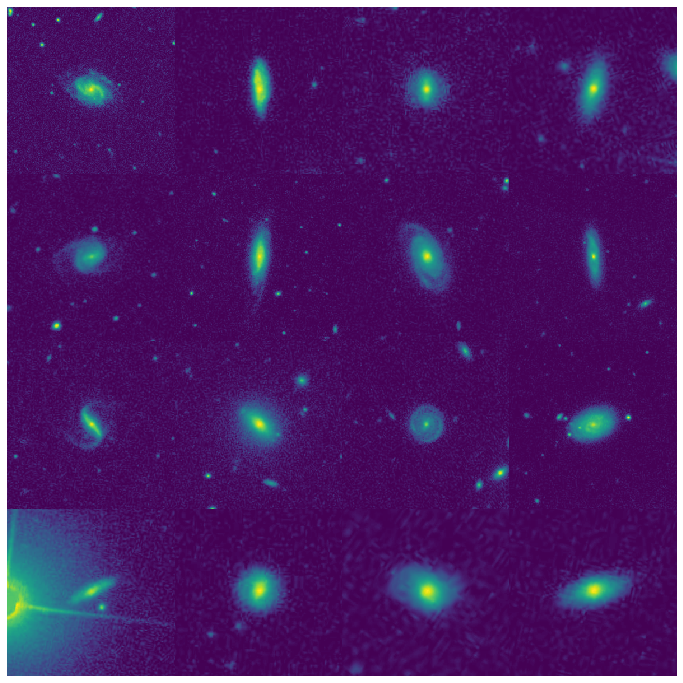

In [11]:
for images, labels in dataset.take(4):
    print(images.shape)
    print(labels.shape)
    
print(labels)

_ = show_galaxies(images.numpy(), nrows=4, ncols=4)

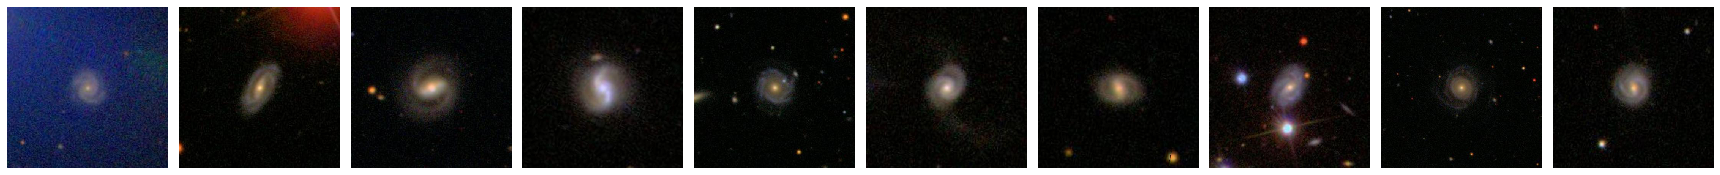

In [38]:
# from_log = ['dr7objid_587739376701865988', 'dr7objid_587738409789489321', 'dr7objid_588017702390202378', 'dr7objid_587735661010878528', 'dr7objid_588018056186888508', 'dr7objid_587739408389767204', 'dr7objid_588017978351222871', 'dr7objid_587729233591009346', 'dr7objid_587734623241109728', 'dr7objid_587739646207656021']
# fig, axes = plt.subplots(ncols=10, figsize=(24, 8))
# for n, id_str in enumerate(from_log[:10]):
#     axes[n].imshow(Image.open(catalog[catalog['id_str'] == id_str].squeeze()['file_loc'].replace('/png/png', '/png')))
#     axes[n].axis('off')
# fig.tight_layout()

In [14]:
# feature_spec = input_utils.get_feature_spec({'id_str': 'string'})
# tfrecord_locs = glob.glob(tfrecord_dir + '/*.tfrecord')
# print(tfrecord_locs)
# id_str_dataset = input_utils.get_dataset(tfrecord_locs, feature_spec, batch_size=1, shuffle=False, repeat=False, drop_remainder=False)
# id_strs = [str(d['id_str'].numpy().squeeze())[2:-1] for d in id_str_dataset]
# print(len(id_strs))
# id_strs[:5]

# fig, axes = plt.subplots(ncols=10, sharex=True, figsize=(36, 6))
# for subject_n in range(10):
#     ax = axes[subject_n]
#     matched_row = catalog[catalog['id_str'] == id_strs[subject_n]].squeeze()
#     loc = matched_row['file_loc']
#     ax.imshow(np.array(Image.open(loc)))

In [ ]:
# import json

# with open('results/temp/temp_ids.json', 'r') as f:
#     top_ids = json.load(f)
# np.mean([x in set(id_strs) for x in top_ids])

In [ ]:
# tfrecord_dir = 'results/temp/latest_dirichlet_active_n5/iteration_1/acquired_tfrecords'
# dataset = get_dataset(tfrecord_dir)

# for images, labels in dataset.take(1):
#     print(images.shape)
#     print(labels.shape)

# _ = show_galaxies(images.numpy(), nrows=4, ncols=4)

In [15]:
tfrecord_dir

'results/temp/latest_dirichlet_unfiltered_active_m3_warm/iteration_1/acquired_tfrecords'

In [16]:
feature_spec = input_utils.get_feature_spec({'id_str': 'string'})
tfrecord_locs = glob.glob(tfrecord_dir + '/*.tfrecord')
print(tfrecord_locs)
id_str_dataset = input_utils.get_dataset(tfrecord_locs, feature_spec, batch_size=1, shuffle=False, repeat=False, drop_remainder=False)
id_strs = [str(d['id_str'].numpy().squeeze())[2:-1] for d in id_str_dataset]
print(len(id_strs))
id_strs[:5]

['results/temp/latest_dirichlet_unfiltered_active_m3_warm/iteration_1/acquired_tfrecords/s300_shard_2.tfrecord', 'results/temp/latest_dirichlet_unfiltered_active_m3_warm/iteration_1/acquired_tfrecords/s300_shard_1.tfrecord', 'results/temp/latest_dirichlet_unfiltered_active_m3_warm/iteration_1/acquired_tfrecords/s300_shard_3.tfrecord', 'results/temp/latest_dirichlet_unfiltered_active_m3_warm/iteration_1/acquired_tfrecords/s300_shard_0.tfrecord']
13653


['dr7objid_587739382062186718',
 'dr7objid_588017721178456205',
 'dr7objid_587741533330210971',
 'dr7objid_587742190451097732',
 'dr7objid_587745244160655525']

In [17]:
catalog['file_loc']

0         /media/walml/beta/gz2/png/png/587738/587738568...
1         /media/walml/beta/gz2/png/png/587734/587734623...
2         /media/walml/beta/gz2/png/png/587732/587732049...
3         /media/walml/beta/gz2/png/png/587742/587742627...
4         /media/walml/beta/gz2/png/png/587739/587739721...
                                ...                        
183823    /media/walml/beta/gz2/png/png/587725/587725039...
183824    /media/walml/beta/gz2/png/png/587729/587729227...
183825    /media/walml/beta/gz2/png/png/587739/587739631...
183826    /media/walml/beta/gz2/png/png/587739/587739406...
183827    /media/walml/beta/gz2/png/png/587739/587739166...
Name: file_loc, Length: 183828, dtype: object

In [23]:
id_str_df = pd.DataFrame(data=[{'id_str': x} for x in id_strs])
len(id_str_df)

13653

In [24]:
id_str_df.head()

,id_str
0,dr7objid_587739382062186718
1,dr7objid_588017721178456205
2,dr7objid_587741533330210971
3,dr7objid_587742190451097732
4,dr7objid_587745244160655525


In [25]:
len(catalog)

183828

In [26]:
df = pd.merge(id_str_df, catalog, on='id_str', how='inner')
len(df)

13653

In [77]:
catalog.columns.values

array(['level_0', 'index', 'dr7objid', 'ra', 'dec', 'sample',
       'smooth-or-featured_smooth', 'smooth-or-featured_featured-or-disk',
       'smooth-or-featured_artifact', 'disk-edge-on_yes',
       'disk-edge-on_no', 'bar_yes', 'bar_no', 'has-spiral-arms_yes',
       'has-spiral-arms_no', 'bulge-size_no',
       'bulge-size_just-noticeable', 'bulge-size_obvious',
       'bulge-size_dominant', 'local_png_loc', 'png_ready',
       'smooth-or-featured_total-votes', 'bar_total-votes',
       'disk-edge-on_total-votes', 'has-spiral-arms_total-votes',
       'bulge-size_total-votes', 'id_str', 'file_loc', 'best_match',
       'sky_separation'], dtype=object)

Text(0.5, 0, 'Smooth')

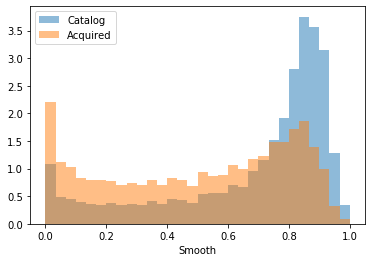

In [100]:
fig, ax = plt.subplots()
_, bins = np.histogram(np.linspace(0., 1.), bins=30)
ax.hist(catalog['smooth-or-featured_smooth'] / catalog['smooth-or-featured_total-votes'], alpha=alpha, label='Catalog', density=True, bins=bins)
ax.hist(df['smooth-or-featured_smooth'] / df['smooth-or-featured_total-votes'], alpha=alpha, label='Acquired', density=True, bins=bins)
plt.legend()
plt.xlabel('Smooth')

33557


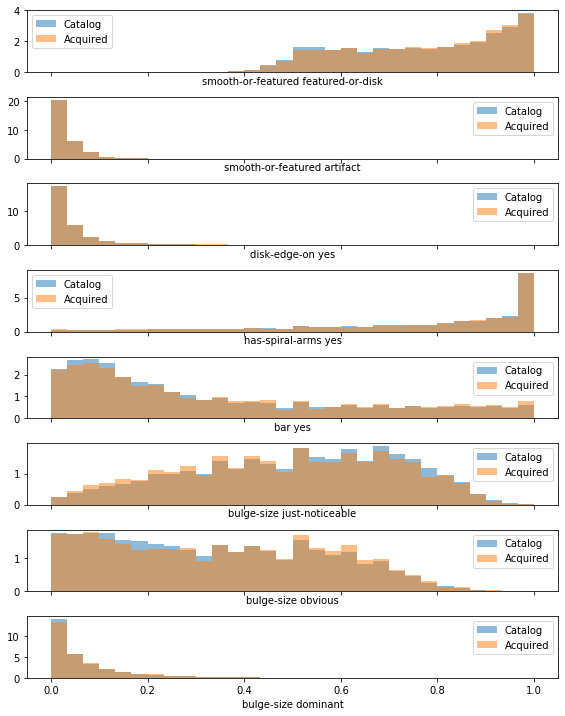

In [96]:
pairs = [
    ('smooth-or-featured', 'featured-or-disk'),
    ('smooth-or-featured', 'artifact'),
    ('disk-edge-on', 'yes'),
    ('has-spiral-arms', 'yes'),
    ('bar', 'yes'),
    ('bulge-size', 'just-noticeable'),
    ('bulge-size', 'obvious'),
    ('bulge-size', 'dominant'),
]

fig, axes = plt.subplots(figsize=(8, 10), nrows=len(pairs), sharex=True)
alpha = .5

cut_catalog = catalog.copy()
cut_catalog = cut_catalog[(cut_catalog['smooth-or-featured_smooth'] / cut_catalog['smooth-or-featured_total-votes']) < 0.5]
cut_catalog = cut_catalog[(cut_catalog['disk-edge-on_no'] / cut_catalog['disk-edge-on_total-votes']) > 0.5]
print(len(cut_catalog))
cut_acquired = df.copy()
cut_acquired = cut_acquired[(cut_acquired['smooth-or-featured_smooth'] / cut_acquired['smooth-or-featured_total-votes']) < 0.5]
cut_acquired = cut_acquired[(cut_acquired['disk-edge-on_no'] / cut_acquired['disk-edge-on_total-votes']) > 0.5]

_, bins = np.histogram(np.linspace(0., 1.), bins=30)

for n, (question, answer) in enumerate(pairs):
    ax = axes[n]
    ax.hist(cut_catalog[question + '_' + answer] / cut_catalog[question + '_total-votes'], alpha=alpha, label='Catalog', density=True, bins=bins)
    ax.hist(cut_acquired[question + '_' + answer] / cut_acquired[question + '_total-votes'], alpha=alpha, label='Acquired', density=True, bins=bins)
    ax.set_xlabel(question + ' ' + answer)
    ax.legend()
    fig.tight_layout()

In [101]:
nsa_catalog_loc = 'data/nsa_v1_0_1.fits'

physical_cols = ['SERSIC_ABSMAG', 'MAG', 'Z', 'SERSIC_MASS', 'PETRO_BA50', 'PETRO_BA90', 'PETRO_THETA', 'CLUMPY', 'ASYMMETRY', 'IAUNAME']
cols_to_load = ['RA', 'DEC'] + physical_cols
nsa_catalog = Table.read(nsa_catalog_loc)[cols_to_load]

for col in cols_to_load:
    nsa_catalog[col.lower()] = nsa_catalog[col]
    del nsa_catalog[col]

In [102]:
nsa_catalog['asymmetry_r'] = nsa_catalog['asymmetry'][:, 4]
nsa_catalog['clumpy_r'] = nsa_catalog['clumpy'][:, 4]
nsa_catalog['sersic_absmag_r'] = nsa_catalog['sersic_absmag'][:, 4]
del nsa_catalog['asymmetry']
del nsa_catalog['clumpy']
del nsa_catalog['sersic_absmag']

In [103]:

nsa_catalog = nsa_catalog.to_pandas()

nsa_df, _ = matching_utils.match_galaxies_to_catalog_pandas(catalog, nsa_catalog, matching_radius=u.arcsec * 1000)

In [104]:
nsa_df['log_sersic_mass'] = np.log10(nsa_df['sersic_mass'])
nsa_catalog['log_sersic_mass'] = np.log10(nsa_catalog['sersic_mass'])

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [105]:
nsa_df['iauname'] = nsa_df['iauname'].str.decode('utf8')

In [106]:
# uploadable = pd.read_csv('/media/walml/beta/decals/catalogs/decals_master_catalog.csv')
# uploadable['iauname']

In [107]:
# nsa_catalog = nsa_catalog[nsa_catalog['iauname'].isin(uploadable['iauname'])]

In [108]:

relevant_physical_cols = ['mag', 'sersic_absmag_r', 'z', 'log_sersic_mass', 'petro_ba50', 'petro_ba90', 'petro_theta', 'asymmetry_r', 'clumpy_r', 'ra', 'dec']

In [64]:


safe_catalog = nsa_df.copy()
for col in relevant_physical_cols:
    values = safe_catalog[col]
    values = values[~np.isnan(values)]
    lower_lim = np.percentile(values, 1)
    upper_lim = np.percentile(values, 99)
    safe_catalog = safe_catalog.query('{} > {}'.format(col, lower_lim)).query('{} < {}'.format(col, upper_lim))
#         print(len(safe_df))
safe_catalog = safe_catalog.dropna(subset=relevant_physical_cols)

In [65]:
assert not any(safe_catalog.duplicated(subset='id_str'))
assert not any(df.duplicated(subset='id_str'))

In [66]:
safe_catalog.columns.values

array(['level_0', 'index', 'dr7objid', 'ra_subject', 'dec_subject',
       'sample', 'smooth-or-featured_smooth',
       'smooth-or-featured_featured-or-disk',
       'smooth-or-featured_artifact', 'disk-edge-on_yes',
       'disk-edge-on_no', 'bar_yes', 'bar_no', 'has-spiral-arms_yes',
       'has-spiral-arms_no', 'bulge-size_no',
       'bulge-size_just-noticeable', 'bulge-size_obvious',
       'bulge-size_dominant', 'local_png_loc', 'png_ready',
       'smooth-or-featured_total-votes', 'bar_total-votes',
       'disk-edge-on_total-votes', 'has-spiral-arms_total-votes',
       'bulge-size_total-votes', 'id_str', 'file_loc', 'best_match',
       'sky_separation', 'ra', 'dec', 'mag', 'z', 'sersic_mass',
       'petro_ba50', 'petro_ba90', 'petro_theta', 'iauname',
       'asymmetry_r', 'clumpy_r', 'sersic_absmag_r', 'log_sersic_mass'],
      dtype=object)

In [67]:
df.columns.values

array(['id_str', 'level_0', 'index', 'dr7objid', 'ra', 'dec', 'sample',
       'smooth-or-featured_smooth', 'smooth-or-featured_featured-or-disk',
       'smooth-or-featured_artifact', 'disk-edge-on_yes',
       'disk-edge-on_no', 'bar_yes', 'bar_no', 'has-spiral-arms_yes',
       'has-spiral-arms_no', 'bulge-size_no',
       'bulge-size_just-noticeable', 'bulge-size_obvious',
       'bulge-size_dominant', 'local_png_loc', 'png_ready',
       'smooth-or-featured_total-votes', 'bar_total-votes',
       'disk-edge-on_total-votes', 'has-spiral-arms_total-votes',
       'bulge-size_total-votes', 'file_loc'], dtype=object)

In [68]:
len(safe_catalog)

146992

In [69]:
safe_catalog.to_csv('results/temp/safe_catalog.csv', index=False)

In [70]:
acquired_df = pd.merge(safe_catalog, df, on='dr7objid', how='inner', suffixes=('_catalog', ''))
len(acquired_df)

10614

In [71]:
acquired_df.columns.values

array(['level_0_catalog', 'index_catalog', 'dr7objid', 'ra_subject',
       'dec_subject', 'sample_catalog',
       'smooth-or-featured_smooth_catalog',
       'smooth-or-featured_featured-or-disk_catalog',
       'smooth-or-featured_artifact_catalog', 'disk-edge-on_yes_catalog',
       'disk-edge-on_no_catalog', 'bar_yes_catalog', 'bar_no_catalog',
       'has-spiral-arms_yes_catalog', 'has-spiral-arms_no_catalog',
       'bulge-size_no_catalog', 'bulge-size_just-noticeable_catalog',
       'bulge-size_obvious_catalog', 'bulge-size_dominant_catalog',
       'local_png_loc_catalog', 'png_ready_catalog',
       'smooth-or-featured_total-votes_catalog',
       'bar_total-votes_catalog', 'disk-edge-on_total-votes_catalog',
       'has-spiral-arms_total-votes_catalog',
       'bulge-size_total-votes_catalog', 'id_str_catalog',
       'file_loc_catalog', 'best_match', 'sky_separation', 'ra_catalog',
       'dec_catalog', 'mag', 'z', 'sersic_mass', 'petro_ba50',
       'petro_ba90', 'petro_t

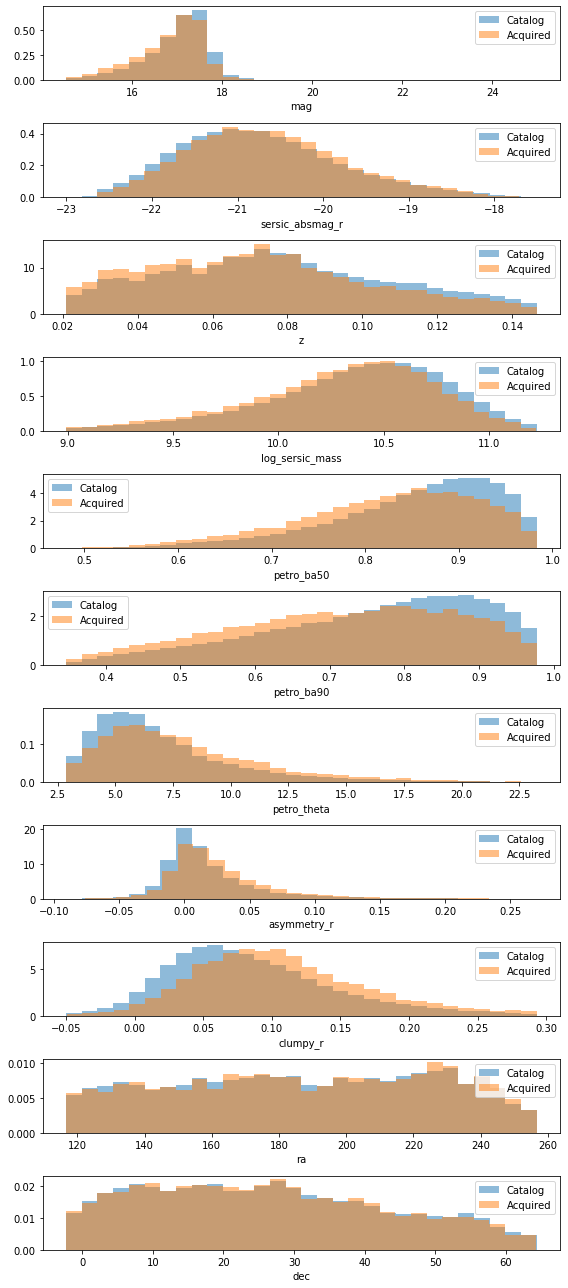

In [72]:
fig, axes = plt.subplots(figsize=(8, 18), nrows=len(relevant_physical_cols))
alpha = .5

# _, bins = np.histogram(np.linspace(0., 1.), bins=30)
bins=30


for (n, col) in enumerate(relevant_physical_cols):
    col = col.lower()
    ax = axes[n]
    ax.hist(safe_catalog[col], alpha=alpha, label='Catalog', density=True, bins=bins)
    ax.hist(acquired_df[col], alpha=alpha, label='Acquired', density=True, bins=bins)
    ax.set_xlabel(col)
    ax.legend()
    fig.tight_layout()

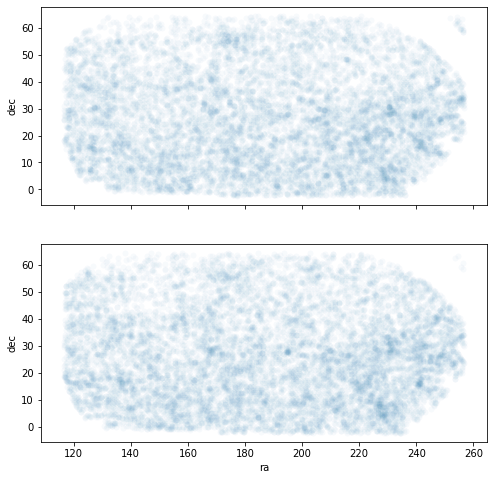

In [74]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
sns.scatterplot(data=safe_catalog.sample(10000), x='ra', y='dec', alpha=.03, ax=axes[0])
sns.scatterplot(data=acquired_df, x='ra', y='dec', alpha=.03, ax=axes[1])
